# CLAHE + ViT: Thoracic Disease Classifier ResNet-50 Architecture (Existing Algo)

Install Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import glob

Matplotlib is building the font cache; this may take a moment.


Split data for training and validation dataset 

In [7]:
BASE_DIR = "dataset/"
CSV_PATH = os.path.join(BASE_DIR, "Data_Entry_2017.csv")

# Find all images inside "image_001/images/" to "image_012/images/"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
IMAGE_FILES = {os.path.basename(f): f for f in glob.glob(os.path.join(IMAGE_DIR, "*.png"))}

# Check if images were found
print(f"Total images found: {len(IMAGE_FILES)}")

Total images found: 112120


In [8]:
# Load CSV
df = pd.read_csv(CSV_PATH)

# Keep only relevant columns
df = df[['Image Index', 'Finding Labels']]

# Convert multi-labels into lists
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# Copy to avoid modifying original
df_filtered = df.copy()

# Binarize the labels
mlb = MultiLabelBinarizer()
binarized_labels = mlb.fit_transform(df_filtered['Finding Labels'])

# Convert binarized labels into a DataFrame with column names
label_columns = mlb.classes_  # Get class names for column headers
df_labels = pd.DataFrame(binarized_labels, columns=label_columns)

# Concatenate with the original DataFrame
df_filtered = pd.concat([df_filtered[['Image Index']], df_labels], axis=1)

# Check label distribution
print(df_labels.sum(axis=0))  # Sum of each class occurrence

df_filtered.head()

Atelectasis           11559
Cardiomegaly           2776
Consolidation          4667
Edema                  2303
Effusion              13317
Emphysema              2516
Fibrosis               1686
Hernia                  227
Infiltration          19894
Mass                   5782
No Finding            60361
Nodule                 6331
Pleural_Thickening     3385
Pneumonia              1431
Pneumothorax           5302
dtype: int64


,Image Index,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [10]:
valid_labels = mlb.classes_
print(valid_labels)  # This is your ordered list of label names

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [5]:
print(df[df['Finding Labels'].apply(lambda x: 'Pneumonia' in x)].head(20))

           Image Index                                     Finding Labels
48    00000013_010.png                [Effusion, Pneumonia, Pneumothorax]
126   00000032_012.png     [Atelectasis, Consolidation, Edema, Pneumonia]
253   00000056_000.png                                [Nodule, Pneumonia]
276   00000061_012.png  [Edema, Effusion, Infiltration, Pleural_Thicke...
279   00000061_015.png                                        [Pneumonia]
590   00000144_001.png                                        [Pneumonia]
614   00000150_002.png             [Atelectasis, Infiltration, Pneumonia]
640   00000165_001.png                                        [Pneumonia]
804   00000193_019.png                                        [Pneumonia]
859   00000211_013.png  [Cardiomegaly, Edema, Effusion, Infiltration, ...
864   00000211_018.png                [Cardiomegaly, Effusion, Pneumonia]
901   00000218_000.png                          [Infiltration, Pneumonia]
902   00000218_001.png                

In [6]:
print(df['Finding Labels'].apply(lambda x: ','.join(x)).value_counts())

Finding Labels
No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis,Consolidation,Edema,Effusion,Infiltration,Pneumonia        1
Atelectasis,Consolidation,Effusion,Emphysema,Mass,Pneumothorax         1
Cardiomegaly,Effusion,Pleural_Thickening,Pneumothorax                  1
Edema,Infiltration,Pneumothorax                                        1
Atelectasis,Consolidation,Mass,Pleural_Thickening,Pneumothorax         1
Name: count, Length: 836, dtype: int64


CLAHE Processing (Applied in Augmentation and Validation)

In [ ]:
def apply_clahe(image):
    # Convert image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge channels back
    limg = cv2.merge((cl, a, b))
    image_clahe = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    return image_clahe

From the System created (Not applied)

In [ ]:
def preprocess_image(image_path):
    # 1. Load the image in grayscale
    orig_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 2. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(orig_img)

    # 3. Resize image for visualization (optional)
    display_img = cv2.resize(clahe_img, (400, 400), interpolation=cv2.INTER_AREA)

    # 4. Resize to model input size (224x224)
    model_img = cv2.resize(clahe_img, (224, 224))

    # 5. Normalize to 0-1 range
    model_img = np.array(model_img, dtype=np.float32) / 255.0

    # 6. Expand dimensions to shape (1, 224, 224, 1) - batch size and channel
    model_img = np.expand_dims(model_img, axis=0)  # Add batch dimension
    model_img = np.expand_dims(model_img, axis=3)  # Add channel dimension

    # 7. Repeat grayscale channel to make it 3-channel (RGB-like)
    model_img = np.repeat(model_img, 3, axis=3)

    return model_img, display_img  # You might want to return both for viewing and inference

Load Dataset and Split

In [ ]:
# Prepare input (X) and labels (y)
X = df_filtered['Image Index'].values  # Image filenames
y = df_filtered[valid_labels].values   # Multi-label one-hot encoding

X_train, X_test, y_train, y_test = train_test_split(S
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

In [ ]:
# Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
    preprocessing_function=apply_clahe,  # Apply CLAHE
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=apply_clahe  # Apply CLAHE to validation and test images
)

BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # Change if needed

# Train generator with augmentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_filtered[df_filtered['Image Index'].isin(X_train)],
    directory='dataset/images',  # Path to images
    x_col="Image Index",
    y_col=valid_labels,  # Multi-label columns
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw"
)

# Validation generator (no augmentation)
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_filtered[df_filtered['Image Index'].isin(X_val)],
    directory='dataset/images',
    x_col="Image Index",
    y_col=valid_labels,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw"
)

# Test generator (for final evaluation)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_filtered[df_filtered['Image Index'].isin(X_test)],
    directory='dataset/images',
    x_col="Image Index",
    y_col=valid_labels,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)

Found 80726 validated image filenames.
Found 8970 validated image filenames.
Found 22424 validated image filenames.


Load ResNet-50 from ImageNet and re-train Classification Head

In [ ]:
# Load ResNet-50 with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False  # Prevents modification

# Add new classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x_class = Dense(128, activation='relu')(x)
x_class = Dropout(0.3)(x_class)
output_class = Dense(len(valid_labels), activation='sigmoid', name='classification_output')(x_class)

# Define and compile model
model = Model(inputs=base_model.input, outputs=output_class)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy', 'AUC'])

# Save the best model based on validation AUC
checkpoint = ModelCheckpoint('classification_head.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Reduce LR if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

callbacks = [checkpoint, reduce_lr]

# Train the classification head only
history = model.fit(
    train_generator,
    epochs=5,  
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

Epoch 1/5
2523/2523 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.5076 - auc: 0.7876
Epoch 1: val_auc improved from -inf to 0.83373, saving model to best_model.h5
2523/2523 [==============================] - 3993s 2s/step - loss: 0.2472 - accuracy: 0.5076 - auc: 0.7876 - val_loss: 0.2158 - val_accuracy: 0.5470 - val_auc: 0.8337 - lr: 1.0000e-04
Epoch 2/5
2523/2523 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.5360 - auc: 0.8153
Epoch 2: val_auc improved from 0.83373 to 0.83404, saving model to best_model.h5
2523/2523 [==============================] - 3840s 2s/step - loss: 0.2256 - accuracy: 0.5360 - auc: 0.8153 - val_loss: 0.2150 - val_accuracy: 0.5470 - val_auc: 0.8340 - lr: 1.0000e-04
Epoch 3/5
2523/2523 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.5363 - auc: 0.8198
Epoch 3: val_auc improved from 0.83404 to 0.83437, saving model to best_model.h5
2523/2523 [==============================] - 3902s 2s/step 

Unfreezing the Last 10 Layers for Transfer Learning

In [12]:
# Unfreeze last 10 layers of ResNet-50
for layer in base_model.layers[-10:]:
    layer.trainable = True

finetune_checkpoint = ModelCheckpoint('thoracic_classifier.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
finetune_callbacks = [finetune_checkpoint, reduce_lr]

# Recompile with a smaller learning rate for fine-tuning
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),  # Lower LR
              metrics=['accuracy', 'AUC'])

# Train again with fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=5, 
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=finetune_callbacks
)

Epoch 1/5
2523/2523 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.5363 - auc: 0.8299
Epoch 1: val_auc improved from -inf to 0.84878, saving model to thoracic_classifier.h5
2523/2523 [==============================] - 3888s 2s/step - loss: 0.2190 - accuracy: 0.5363 - auc: 0.8299 - val_loss: 0.2132 - val_accuracy: 0.5470 - val_auc: 0.8488 - lr: 1.0000e-05
Epoch 2/5
2523/2523 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.5363 - auc: 0.8349
Epoch 2: val_auc improved from 0.84878 to 0.85282, saving model to thoracic_classifier.h5
2523/2523 [==============================] - 3869s 2s/step - loss: 0.2168 - accuracy: 0.5363 - auc: 0.8349 - val_loss: 0.2073 - val_accuracy: 0.5470 - val_auc: 0.8528 - lr: 1.0000e-05
Epoch 3/5
2523/2523 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.5363 - auc: 0.8363
Epoch 3: val_auc did not improve from 0.85282
2523/2523 [==============================] - 3850s 2s/step - loss: 0.2160 - 

Testing the Model

In [13]:
# Load the best model saved during training
model = load_model('thoracic_classifier.h5')

1/1 [==============================] - 0s 57ms/step


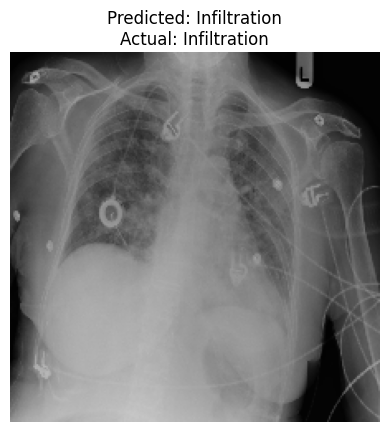

In [43]:
# Get a batch of images and labels from the test generator
batch_images, batch_labels = next(iter(test_generator))

# Predict on the batch
batch_preds = model.predict(batch_images)

# Choose a random image from the batch
idx = np.random.randint(len(batch_images))
img = batch_images[idx]
true_label = batch_labels[idx]
pred_label = (batch_preds[idx] > 0.19).astype(int) # Lowered threshhold for better simulations (for now)

# Convert one-hot encoded labels back to class names
true_label_names = [valid_labels[i] for i in range(len(valid_labels)) if true_label[i] == 1]
pred_label_names = [valid_labels[i] for i in range(len(valid_labels)) if pred_label[i] == 1]

# Removes "No Finding" if there are other predicted labels
if "No Finding" in pred_label_names and len(pred_label_names) > 1:
    pred_label_names.remove("No Finding")

# Show the image
plt.imshow(img)
plt.axis('off')

# Display the predicted and actual labels
plt.title(f"Predicted: {', '.join(pred_label_names)}\nActual: {', '.join(true_label_names)}") 
plt.show()

Save the Model

In [44]:
model.save('final_model.h5')  # Saves as HDF5 format
model.save('final_model.keras')  # Saves as Keras format

Evaluation

701/701 [==============================] - 725s 1s/step


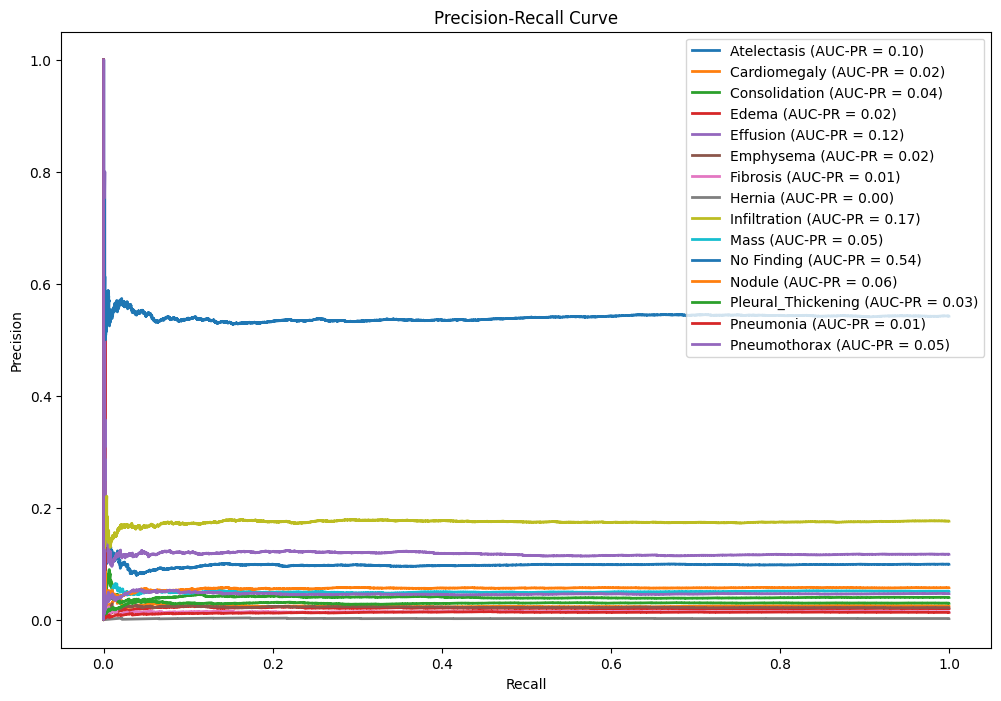

In [14]:
from sklearn.metrics import precision_recall_curve, auc

# Predict probabilities for test set
y_pred = model.predict(test_generator)

# Compute Precision-Recall and AUC-PR for each class
precision = dict()
recall = dict()
auc_pr = dict()
for i in range(len(valid_labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    auc_pr[i] = auc(recall[i], precision[i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(12, 8))
for i in range(len(valid_labels)):
    plt.plot(recall[i], precision[i], lw=2, label=f'{valid_labels[i]} (AUC-PR = {auc_pr[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()
